In [4]:
!python --version

Python 3.10.12


In [2]:
import os
import numpy as np
from sklearn.preprocessing import label_binarize
from keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Input, Flatten, Add, concatenate, Embedding, Convolution1D, Dropout, Dense, Bidirectional,Dense, Activation,Conv2D,BatchNormalization,MultiHeadAttention,LayerNormalization,Reshape,Attention

from keras.optimizers import SGD, Adam, RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import sequence
from keras import optimizers


2023-08-08 16:04:23.063949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-08 16:04:23.914566: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:

emotions_used = np.array(['ang', 'exc', 'neu', 'sad'])


In [4]:
# read already saved pickle data
import pickle
with open(data_path +'data.pickle', 'rb') as handle:
    data2 = pickle.load(handle)

In [5]:
text = []

for ses_mod in data2:
    text.append(ses_mod['transcription'])
    
MAX_SEQUENCE_LENGTH = 500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)

token_tr_X = tokenizer.texts_to_sequences(text)
x_train_text = []

x_train_text = sequence.pad_sequences(token_tr_X, maxlen=MAX_SEQUENCE_LENGTH)

In [6]:
import codecs
EMBEDDING_DIM = 300

word_index = tokenizer.word_index
print('Found %s unique tokens' % len(word_index))

#file_loc = data_path + '../glove.42B.300d.txt'
file_loc = 'glove.840B.300d.txt'
print (file_loc)

gembeddings_index = {}
with codecs.open(file_loc, encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        gembedding = np.asarray(values[1:], dtype='float32')
        gembeddings_index[word] = gembedding
#
f.close()
print('G Word embeddings:', len(gembeddings_index))

nb_words = len(word_index) +1
g_word_embedding_matrix = np.zeros((nb_words, EMBEDDING_DIM))
for word, i in word_index.items():
    gembedding_vector = gembeddings_index.get(word)
    if gembedding_vector is not None:
        g_word_embedding_matrix[i] = gembedding_vector
        
print('G Null word embeddings: %d' % np.sum(np.sum(g_word_embedding_matrix, axis=1) == 0))

Found 2736 unique tokens
glove.840B.300d.txt
G Word embeddings: 2196018
G Null word embeddings: 100


In [10]:
x_train_speech = np.load('speech.npy')
print(x_train_speech.shape)
x_train_new = x_train_speech.reshape((x_train_speech.shape[0],x_train_speech.shape[1],x_train_speech.shape[2],1))
print(x_train_new.shape)
inputshape= x_train_new.shape

(4936, 100, 34)
(4936, 100, 34, 1)


In [11]:
# read output label
Y=[]
for ses_mod in data2:
    Y.append(ses_mod['emotion'])
    
Y = label_binarize(y=Y,classes=emotions_used)

Y.shape

(4936, 4)

In [1]:
# layer = MultiHeadAttention(num_heads =2, key_dim =64, use_bias=False)
# layer_vanilla = Attention()
# norm2 = LayerNormalization(epsilon=1e-6)

# from keras_nlp.layers import TransformerEncoder
# encoder = TransformerEncoder(intermediate_dim=64, num_heads=8)
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2023-08-10 10:14:23.472205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-10 10:14:24.630867: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Num GPUs Available:  4


In [14]:
# USE Keras API model
text_input = Input(shape=(MAX_SEQUENCE_LENGTH,))
model_text = Embedding(nb_words,
                      EMBEDDING_DIM,
                      weights = [g_word_embedding_matrix],
                      input_length = MAX_SEQUENCE_LENGTH)(text_input)
conv1 = Convolution1D(256, 3, padding='same', activation='relu')(model_text)
conv2 = Convolution1D(128, 3, padding='same', activation='relu')(conv1)
conv3 = Convolution1D(64, 3, padding='same', activation='relu')(conv2)
conv4 = Convolution1D(128, 3, padding='same', activation='relu')(conv3)
flat = Flatten()(conv4)
out_text = Dense(256)(flat)

speech_input = Input(shape=(100,34))
model_speech1 = Flatten()(speech_input)
model_speech2 = Dense(1024, activation='relu')(model_speech1)
model_speech3 = Dense(512, activation='relu')(model_speech2)
out_speech = Dense(256, activation='relu')(model_speech3)

# model_combined1 = concatenate([out_text, out_speech])
# # model_combined1 = Reshape((2,256))(model_combined1)
# att = encoder.call(model_combined1)
# # x3 = norm2(att)
# # x3 = layer_vanilla([model_combined1,model_combined1])

encoder_input  = tf.keras.layers.Concatenate()([out_text,out_speech])
encoder_input = tf.keras.layers.Reshape((2,256))(encoder_input)
output_t = encoder(encoder_input)
output_t = tf.keras.layers.Reshape((1,512))(output_t)

current_shape = output_t.shape.as_list()

new_shape = (-1, current_shape[-1])
output_t = tf.reshape(output_t, new_shape)

model_combined2 = Dense(256, activation='relu')(output_t)
model_combined3 = Dense(4, activation='softmax')(model_combined2)

# model compile
model_combined = Model([text_input, speech_input], model_combined3)
model_combined.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

2023-08-08 16:08:16.657273: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6644 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:02:00.0, compute capability: 7.5
2023-08-08 16:08:16.657987: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 1114 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:04:00.0, compute capability: 7.5
2023-08-08 16:08:16.658596: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 3476 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2070, pci bus id: 0000:83:00.0, compute capability: 7.5
2023-08-08 16:08:16.659252: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1639] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 6644 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 2070, pc

In [15]:
hist = model_combined.fit([x_train_text, x_train_speech], Y, batch_size=32, epochs=50, verbose=1, validation_split=0.2)


Epoch 1/50


2023-08-08 16:08:20.086063: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53692800 exceeds 10% of free system memory.
2023-08-08 16:08:20.178136: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 53692800 exceeds 10% of free system memory.
2023-08-08 16:08:28.704830: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-08-08 16:08:29.463015: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-08-08 16:08:29.737645: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x10f417d80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-08-08 16:08:29.737685: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2070, Compute Capability 7.5
2023-08-08 16:08:29.737699: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeFo

124/124 [==============================] - 30s 133ms/step - loss: 1.4628 - acc: 0.3151 - val_loss: 1.4651 - val_acc: 0.2905
Epoch 2/50
124/124 [==============================] - 7s 53ms/step - loss: 1.1209 - acc: 0.4752 - val_loss: 1.0274 - val_acc: 0.5547
Epoch 3/50
124/124 [==============================] - 4s 34ms/step - loss: 0.9466 - acc: 0.5985 - val_loss: 1.0062 - val_acc: 0.6093
Epoch 4/50
124/124 [==============================] - 3s 28ms/step - loss: 0.7914 - acc: 0.6735 - val_loss: 1.0370 - val_acc: 0.5982
Epoch 5/50
124/124 [==============================] - 3s 26ms/step - loss: 0.6506 - acc: 0.7378 - val_loss: 0.9048 - val_acc: 0.6498
Epoch 6/50
124/124 [==============================] - 3s 26ms/step - loss: 0.5478 - acc: 0.7933 - val_loss: 1.0563 - val_acc: 0.6457
Epoch 7/50
124/124 [==============================] - 3s 25ms/step - loss: 0.4398 - acc: 0.8440 - val_loss: 0.9976 - val_acc: 0.6498
Epoch 8/50
124/124 [==============================] - 3s 23ms/step - loss: 0.3

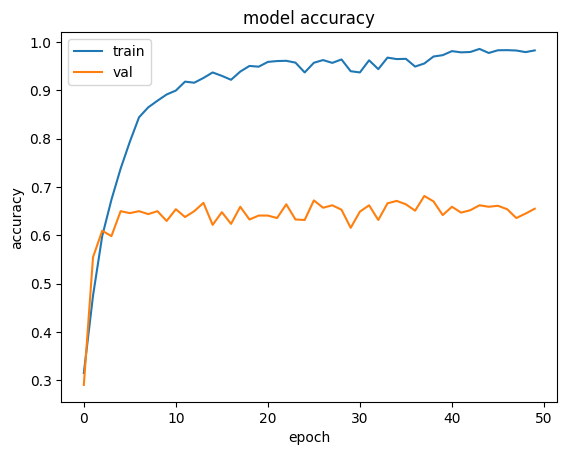

In [16]:
from matplotlib import pyplot as plt
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
dot_img_file = '/tmp/model_1.png'
tf.keras.utils.plot_model(model_combined, to_file=dot_img_file, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [37]:
model_combined.summary(0)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_23 (InputLayer)       [(None, 500)]                0         []                            
                                                                                                  
 embedding_11 (Embedding)    (None, 500, 300)             821100    ['input_23[0][0]']            
                                                                                                  
 conv1d_44 (Conv1D)          (None, 500, 256)             230656    ['embedding_11[0][0]']        
                                                                                                  
 conv1d_45 (Conv1D)          (None, 500, 128)             98432     ['conv1d_44[0][0]']           
                                                                                            

In [ ]:
cle